# Cassava Leaf Disease Classification
Identify the type of disease present on a Cassava Leaf image

As the second-largest provider of carbohydrates in Africa, cassava is a key food security crop grown by smallholder farmers because it can withstand harsh conditions. At least 80% of household farms in Sub-Saharan Africa grow this starchy root, but viral diseases are major sources of poor yields. With the help of data science, it may be possible to identify common diseases so they can be treated.

Existing methods of disease detection require farmers to solicit the help of government-funded agricultural experts to visually inspect and diagnose the plants. This suffers from being labor-intensive, low-supply and costly. As an added challenge, effective solutions for farmers must perform well under significant constraints, since African farmers may only have access to mobile-quality cameras with low-bandwidth.

In this competition, we introduce a dataset of 21,367 labeled images collected during a regular survey in Uganda. Most images were crowdsourced from farmers taking photos of their gardens, and annotated by experts at the National Crops Resources Research Institute (NaCRRI) in collaboration with the AI lab at Makerere University, Kampala. This is in a format that most realistically represents what farmers would need to diagnose in real life.

Your task is to classify each cassava image into four disease categories or a fifth category indicating a healthy leaf. With your help, farmers may be able to quickly identify diseased plants, potentially saving their crops before they inflict irreparable damage.

**Recommended Tutorial**  
We highly recommend [Jesse Mostipak’s Getting Started Tutorial](https://www.kaggle.com/jessemostipak/getting-started-tpus-cassava-leaf-disease) that walks you through making your very first submission step by step.

Acknowledgements
----------------

The **Makerere Artificial Intelligence (AI) Lab** is an AI and Data Science research group based at Makerere University in Uganda. The lab specializes in the application of artificial intelligence and data science - including for example, methods from machine learning, computer vision and predictive analytics to problems in the developing world. Their mission is: “To advance Artificial Intelligence research to solve real-world challenges."

We thank the different experts and collaborators from **National Crops Resources Research Institute (NaCRRI)** for assisting in preparing this dataset.

  

> **This is a Code Competition. Refer to [Code Requirements](https://www.kaggle.com/c/cassava-leaf-disease-classification/overview/code-requirements) for details.**

Dataset Description
-------------------

Can you identify a problem with a cassava plant using a photo from a relatively inexpensive camera? This competition will challenge you to distinguish between several diseases that cause material harm to the food supply of many African countries. In some cases the main remedy is to burn the infected plants to prevent further spread, which can make a rapid automated turnaround quite useful to the farmers.

### Files

**\[train/test\]\_images** the image files. The full set of test images will only be available to your notebook when it is submitted for scoring. Expect to see roughly 15,000 images in the test set.

**train.csv**

*   `image_id` the image file name.
    
*   `label` the ID code for the disease.
    

**sample\_submission.csv** A properly formatted sample submission, given the disclosed test set content.

*   `image_id` the image file name.
    
*   `label` the predicted ID code for the disease.
    

**\[train/test\]\_tfrecords** the image files in tfrecord format.

**label\_num\_to\_disease\_map.json** The mapping between each disease code and the real disease name.

Link: https://www.kaggle.com/c/cassava-leaf-disease-classification

#### Help

* https://www.kaggle.com/code/yasufuminakama/cassava-resnext50-32x4d-starter-training 
* https://www.kaggle.com/japandata509/ensemble-resnext50-32x4d-efficientnet-0-903
* https://www.kaggle.com/code/tanlikesmath/cassava-classification-eda-fastai-starter

In [1]:
import albumentations as A
import numpy as np
import pandas as pd
import timm
from fastai.vision.all import *
from sklearn.model_selection import train_test_split

/home/alxgrin/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/alxgrin/anaconda3/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
train_df = pd.read_csv(
    "../../data/cassava-leaf-disease-classification/train.csv"
).set_index("image_id")
train_df

,label
image_id,
1000015157.jpg,0
1000201771.jpg,3
100042118.jpg,1
1000723321.jpg,1
1000812911.jpg,3
...,...
999068805.jpg,3
999329392.jpg,3
999474432.jpg,1


<IPython.core.display.Javascript object>

In [4]:
train_df["label"].value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

<IPython.core.display.Javascript object>

In [5]:
labels = pd.read_json(
    "../../data/cassava-leaf-disease-classification/label_num_to_disease_map.json",
    orient="index",
)
labels.columns = ["Name"]
labels

,Name
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


<IPython.core.display.Javascript object>

In [6]:
train_df["imagePath"] = train_df.index.map(
    lambda image_id: "../../data/cassava-leaf-disease-classification/train_images/{}".format(
        image_id
    )
)
train_df

,label,imagePath
image_id,,
1000015157.jpg,0,../../data/cassava-leaf-disease-classification/train_images/1000015157.jpg
1000201771.jpg,3,../../data/cassava-leaf-disease-classification/train_images/1000201771.jpg
100042118.jpg,1,../../data/cassava-leaf-disease-classification/train_images/100042118.jpg
1000723321.jpg,1,../../data/cassava-leaf-disease-classification/train_images/1000723321.jpg
1000812911.jpg,3,../../data/cassava-leaf-disease-classification/train_images/1000812911.jpg
...,...,...
999068805.jpg,3,../../data/cassava-leaf-disease-classification/train_images/999068805.jpg
999329392.jpg,3,../../data/cassava-leaf-disease-classification/train_images/999329392.jpg
999474432.jpg,1,../../data/cassava-leaf-disease-classification/train_images/999474432.jpg


<IPython.core.display.Javascript object>

In [7]:
!ls ../../data/cassava-leaf-disease-classification/test_images

2216849948.jpg


<IPython.core.display.Javascript object>

In [8]:
test_df = pd.DataFrame(
    {
        "image_id": ["2216849948.jpg"],
        "imagePath": [
            "../../data/cassava-leaf-disease-classification/train_images/2216849948.jpg"
        ],
    }
).set_index("image_id")
test_df

,imagePath
image_id,
2216849948.jpg,../../data/cassava-leaf-disease-classification/train_images/2216849948.jpg


<IPython.core.display.Javascript object>

# Prepare

In [9]:
X_train, X_true = train_test_split(train_df, test_size=0.1, random_state=42)
X_train.shape, X_true.shape

((19257, 2), (2140, 2))

<IPython.core.display.Javascript object>

In [10]:
BATCH_SIZE = 10
IMAGE_SIZE = 456

<IPython.core.display.Javascript object>

In [11]:
def get_tfms(valid=False):
    if valid:
        return A.Compose(
            [
                A.CenterCrop(IMAGE_SIZE, IMAGE_SIZE, p=1.0),
                A.Resize(IMAGE_SIZE, IMAGE_SIZE),
            ],
            p=1.0,
        )

    return A.Compose(
        [
            A.RandomResizedCrop(IMAGE_SIZE, IMAGE_SIZE),
            A.Transpose(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.HueSaturationValue(
                hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5
            ),
            A.RandomBrightnessContrast(
                brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5
            ),
            A.CoarseDropout(p=0.5),
            A.CoarseDropout(p=0.5),
        ]
    )


get_tfms()

Compose([
  RandomResizedCrop(always_apply=False, p=1.0, height=456, width=456, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=1),
  Transpose(always_apply=False, p=0.5),
  HorizontalFlip(always_apply=False, p=0.5),
  VerticalFlip(always_apply=False, p=0.5),
  ShiftScaleRotate(always_apply=False, p=0.5, shift_limit_x=(-0.0625, 0.0625), shift_limit_y=(-0.0625, 0.0625), scale_limit=(-0.09999999999999998, 0.10000000000000009), rotate_limit=(-45, 45), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box'),
  HueSaturationValue(always_apply=False, p=0.5, hue_shift_limit=(-0.2, 0.2), sat_shift_limit=(-0.2, 0.2), val_shift_limit=(-0.2, 0.2)),
  RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), brightness_by_max=True),
  CoarseDropout(always_apply=False, p=0.5, max_holes=8, max_height=8, max_width=8, min_holes=8, min_height=8, min_width=8, fill_value=0, mask_fill_value=None),
  Co

<IPython.core.display.Javascript object>

In [12]:
# https://docs.fast.ai/tutorial.albumentations.html#using-different-transform-pipelines-and-the-datablock-api
class AlbumentationsTransform(RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx, order = None, 2

    def __init__(self, train_aug, valid_aug):
        store_attr()

    def before_call(self, b, split_idx):
        self.idx = split_idx

    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))["image"]
        else:
            aug_img = self.valid_aug(image=np.array(img))["image"]
        return PILImage.create(aug_img)

<IPython.core.display.Javascript object>

In [13]:
item_tfms = AlbumentationsTransform(get_tfms(), get_tfms(valid=True))

dls = ImageDataLoaders.from_df(
    X_train[["imagePath", "label"]],
    valid_pct=0.2,
    seed=42,
    bs=BATCH_SIZE,
    item_tfms=item_tfms,
)

<IPython.core.display.Javascript object>

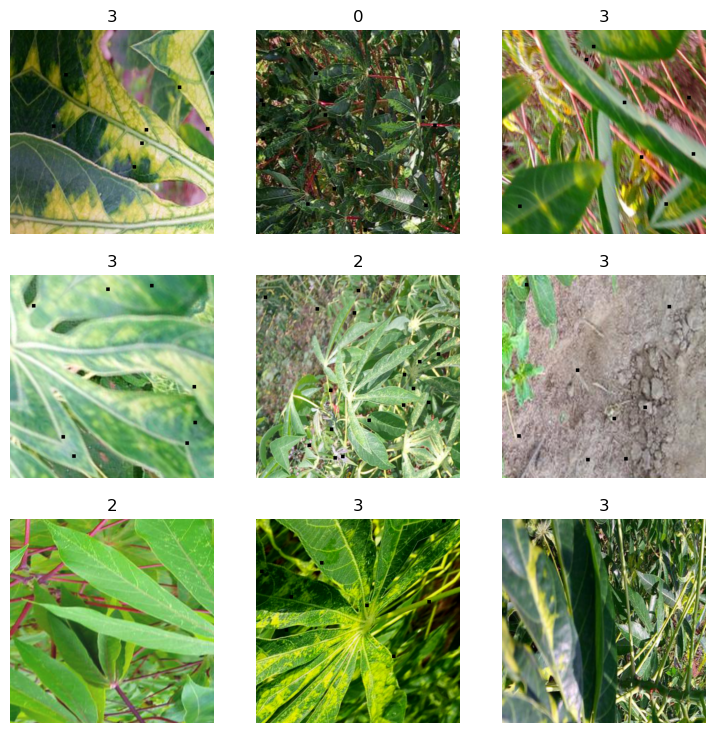

<IPython.core.display.Javascript object>

In [14]:
dls.train.show_batch()

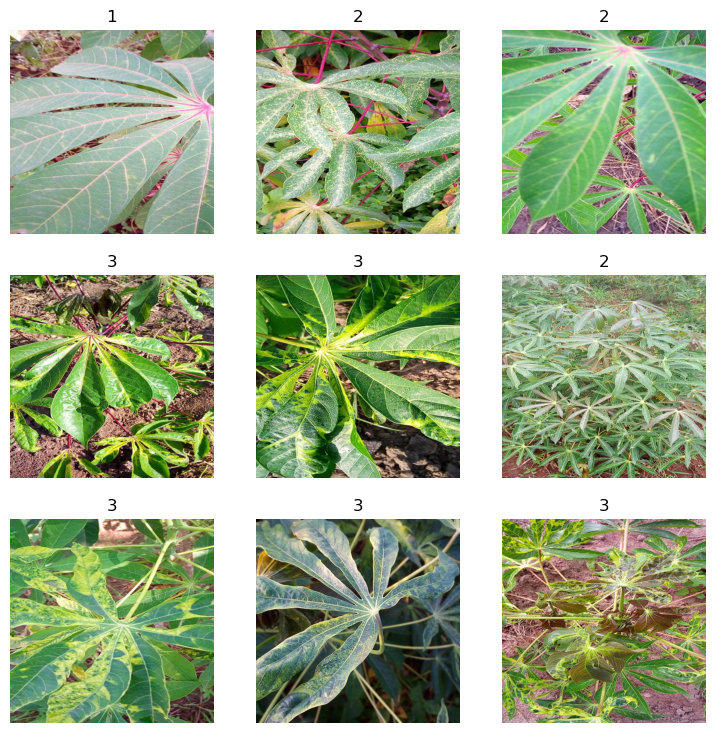

<IPython.core.display.Javascript object>

In [15]:
dls.valid.show_batch()

# Train

In [16]:
model = timm.create_model("tf_efficientnet_b5_ns", pretrained=True, num_classes=dls.c)

learn = Learner(
    dls,
    model,
    opt_func=ranger,
    loss_func=LabelSmoothingCrossEntropy(),
    cbs=[GradientAccumulation(n_acc=32)],
    metrics=accuracy,
).to_fp16()
learn

<IPython.core.display.Javascript object>

SuggestedLRs(valley=0.0002290867705596611)

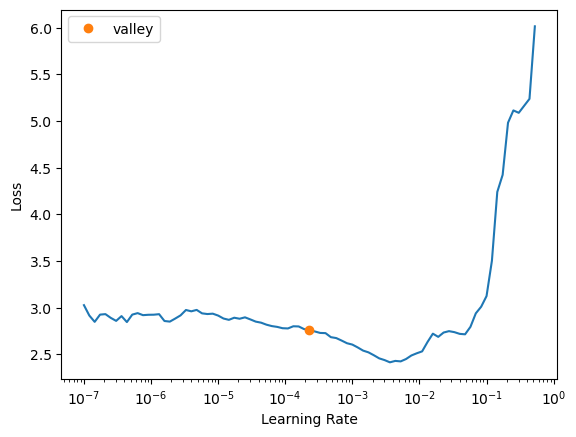

<IPython.core.display.Javascript object>

In [17]:
learn.lr_find()

In [18]:
# https://www.kaggle.com/code/tanlikesmath/cassava-classification-eda-fastai-starter?scriptVersionId=49791813&cellId=39
learn.freeze()
learn.fit_flat_cos(1, 1e-1, wd=0.1, cbs=[MixUp()])

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 

<IPython.core.display.Javascript object>

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.unfreeze()
learn.fit_flat_cos(
    40,
    1e-3,
    cbs=[
        MixUp(),
        SaveModelCallback(
            monitor="accuracy", comp=np.greater, with_opt=True,fname="tf_efficientnet_b5_ns"
        ),
    ],
)

In [ ]:
learn.recorder.plot_loss()

# Validate

In [ ]:
test_dl = dls.test_dl(X_true[["imagePath", "label"]])
test_dl.show_batch()

In [ ]:
# learn = learn.load("tf_efficientnet_b5_ns")

In [ ]:
preds, _ = learn.tta(dl=test_dl, n=5, beta=0)
preds

In [ ]:
(X_true["label"] == preds.argmax(dim=-1).numpy()).sum() / len(X_true)